In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [ ]:
import numpy as np
import pandas as pd
data = pd.read_csv('accepted_2007_to_2018Q4.csv',parse_dates=['issue_d'], infer_datetime_format=True)
data.drop(data.tail(2).index, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
num_feat = ['acc_now_delinq','acc_open_past_24mths','all_util','annual_inc','avg_cur_bal','bc_open_to_buy','bc_util',
            'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti','earliest_cr_line',
            'fico_range_high','fico_range_low','il_util','inq_fi','inq_last_12m','inq_last_6mths','installment','int_rate',
            'last_fico_range_high','last_fico_range_low','max_bal_bc','mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
            'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_last_delinq','mths_since_last_major_derog',
            'mths_since_last_record','mths_since_rcnt_il','mths_since_recent_bc','mths_since_recent_bc_dlq',
            'mths_since_recent_inq','mths_since_recent_revol_delinq','num_accts_ever_120_pd','num_actv_bc_tl',
            'num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0',
            'num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_acc_6m',
            'open_il_12m','open_il_24m','open_rv_12m','open_rv_24m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec',
            'pub_rec_bankruptcies','revol_util','tot_coll_amt','tot_cur_bal','tot_hi_cred_lim','total_acc','total_bal_ex_mort',
            'total_bal_il','total_bc_limit','total_cu_tl','total_il_high_credit_limit','total_rev_hi_lim']

cat_feat = ['term','verification_status','sub_grade']

X = data[ ['issue_d'] + cat_feat + num_feat].copy()
#X.info()

# The features earliest_cr_line is date and its type should be changed to datetime. Later 
# it need to be transformed to ordinal numeric features
X['earliest_cr_line'] = pd.to_numeric(pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True))

#print(data['loan_status'].value_counts())
y = data['loan_status'].copy()
y = (~y.isin(['Current', 'Fully Paid', 'In Grace Period'])).astype('int')
y.value_counts()

del data

In [ ]:
cat_feat = X.select_dtypes('object').columns.values
print(X[cat_feat].nunique().sort_values())

X['term'].replace([' 36 months',' 60 months'], [int(0), int(1)], inplace=True)

X['verification_status'].replace(['Not Verified','Source Verified', 'Verified'], [int(0), int(1), int(2)], inplace=True)

X['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',
                        'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5',
                        'G1','G2','G3','G4','G5'], [int(x) for x in range(35)], inplace=True)

#%%
print(X.shape)

idx = np.where(
    (X['annual_inc'] <= 250000) & (X['dti'] <= 50) & (X['open_acc'] <= 40) &
    (X['total_acc'] <= 80) & (X['revol_util'] <= 120) & (X['earliest_cr_line'] > -2E18)
    )[0]
X = X.iloc[idx]
y = y.iloc[idx]
print(X.shape)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

idx = np.where(X['issue_d'].dt.year < 2017.)[0]
X_train = X.iloc[idx].drop('issue_d', axis='columns')
y_train = y.iloc[idx]

idx = np.where( (X['issue_d'].dt.year == 2017.)&(X['issue_d'].dt.month < 8.) )[0]
X_val = X.iloc[idx].drop('issue_d', axis='columns')
y_val = y.iloc[idx]

idx = np.where( ((X['issue_d'].dt.year == 2017.)&(X['issue_d'].dt.month >= 8.))|(X['issue_d'].dt.year >= 2018.) )[0]
X_test = X.iloc[idx].drop('issue_d', axis='columns')
y_test = y.iloc[idx]

print('Training prob Bad',np.mean(y_train))
print('Validation prob Bad',np.mean(y_val))
print('Test prob Bad',np.mean(y_test))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

term                    2
verification_status     3
sub_grade              35
dtype: int64
(2260699, 76)
(2213429, 76)
Training prob Bad 0.1750958388833793
Validation prob Bad 0.12304089505846083
Test prob Bad 0.05269638093425369
(1304794, 75)
(236141, 75)
(672494, 75)


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.keras.backend.clear_session()
 
class BatchNormFCLayer(tf.keras.layers.Layer):  # for the case of fully connected (1D inputs)
    """
    We create class variables such as gamma and beta to be trained. Also creating pop_mean and pop_var
    that are expected to grow up to obtain estimates for the population mean and population variance.
    The exponential moving average is simple and lets us avoid extra work than moving average.
    It is known that the α of the EMA is associated with window length n like this: α =2/(n+1)
    """
    def __init__(self, decay = 0.999, epsilon=0.00000001):
        """
        :param epsilon:
        :param decay:
        """
        super().__init__()
        gamma_init = tf.ones_initializer()
        self.gamma = tf.Variable(initial_value=gamma_init(shape=[1], dtype='float32'), trainable=True)
       
        beta_init = tf.zeros_initializer()
        self.beta = tf.Variable(initial_value=beta_init(shape=[1], dtype='float32'), trainable=True)
       
        self.decay = decay
        self.epsilon = epsilon
    """
    In general, we might need to know the shape of the input before runtime in which case we can implement
    the build() method in our layer which takes input_shape as a parameter and is called when we compile.
    """
    def build(self, input_shape):  # should pass shape for our variable
        self.pop_mean = tf.Variable(tf.zeros([input_shape[-1]]), trainable=False)
        self.pop_var = tf.Variable(tf.ones([input_shape[-1]]), trainable=False)
        super().build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, mask=None, training=None):  # Defines the computation from inputs to outputs
        """
        DON'T USE 'training=True' when built by Functional API. If doing that then we force the layer be in
        the training mode even during the inference.
        Example:
        inputs = tf.keras.Input(shape=(10))
        x = tf.keras.layers.Dropout(rate=0.5)(inputs, training=True) #<- take training=True out makes inference correct
        model = tf.keras.Model(inputs=inputs,outputs=x)
        model.predict(tf.constant([1]*10))
        """
        if mask is None:
            mask = tf.ones_like(inputs)
        prob_mask = tf.math.divide_no_nan(mask, tf.math.reduce_sum( mask, axis=0 ))  # Mask: real value = 1, NaN value = 0

        mu = tf.math.reduce_sum( tf.math.multiply_no_nan(inputs, prob_mask) , axis=0 )
        variance = tf.math.reduce_sum( tf.math.multiply_no_nan( inputs**2, prob_mask) , axis=0 ) - mu ** 2

        if training:  # In case of training, perform batch normalization to learn beta and gamma
            self.pop_mean.assign( self.pop_mean * self.decay + mu * (1 - self.decay) )
            self.pop_var.assign( self.pop_var * self.decay + variance * (1 - self.decay) )
            #outputs = tf.nn.batch_normalization(inputs, mu, variance, self.beta, self.gamma, K.epsilon())
            x_hat = (inputs - mu)/tf.sqrt(tf.maximum(variance, K.epsilon()))
           
        else:  # In case of testing - calculation of the inference model
            #outputs = tf.nn.batch_normalization(inputs, self.pop_mean, self.pop_var, self.beta, self.gamma, K.epsilon())
            x_hat = (inputs - self.pop_mean)/tf.sqrt(tf.maximum(self.pop_var, K.epsilon()))
           
        x_hat = tf.math.multiply_no_nan(x_hat, mask) # put non-real value to zeros
        outputs = self.gamma * x_hat + self.beta # + (mask-1)*9 # replace non-real value
        return outputs

class GBN(tf.keras.layers.Layer):
    """
    Ghost Batch Normalization
    https://arxiv.org/abs/1705.08741
    """
    def __init__(self, batch_size, virtual_batch_size, decay=0.999):
        super(GBN, self).__init__()
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.num_splits = int(np.ceil(self.batch_size / self.virtual_batch_size))
        self.bn = BatchNormFCLayer(decay)
    
    def build(self, input_shape):
        self.bn.build(input_shape)
        super().build(input_shape)

    def call(self, inputs, mask=None, training=None):
        if tf.math.ceil(tf.shape(inputs)[0] / self.virtual_batch_size)< self.num_splits:
            if mask is None:
                res = self.bn(inputs, None, training)
            else:
                res = self.bn(inputs, mask, training)
            output = res
        else:
            inp_chunks = tf.split(inputs, self.num_splits, axis=0)
            if mask is None:
                res = [self.bn(x_, None, training) for x_ in inp_chunks]
            else:
                mask_chunks = tf.split(mask, self.num_splits, axis=0)
                res = [self.bn(x_, m_, training) for x_, m_ in zip(inp_chunks, mask_chunks)]
            output = tf.concat(res, axis=0)
        
        return output

def scaled_dot_product_attention(q, k, v, mask=None):
    """Calculate the attention weights.
    Args:
        q: query shape == [..., seq_len_q, depth]
        k: key shape == [..., seq_len_k, depth]
        v: value shape == [..., seq_len_v, depth_v]
        mask: Float tensor with shape broadcastable to [..., seq_len_q, seq_len_k].
    
    Returns:
        output, attention_weights
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # [..., seq_len_q, seq_len_k]
    output = tf.matmul(attention_weights, v)  # [..., seq_len_q, depth_v]
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, output_dim):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(output_dim)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into [num_heads, depth].
        Transpose the result such that the shape is [batch_size, num_heads, seq_len, depth]
        """
        # [batch_size, seq_len, num_heads, depth]
        x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]  # q.shape: [batch_size, seq_len, d_model]
        
        q = self.wq(q)  # [batch_size, seq_len, d_model]
        k = self.wk(k)  # [batch_size, seq_len, d_model]
        v = self.wv(v)  # [batch_size, seq_len, d_model]
        
        q = self.split_heads(q, batch_size)  # [batch_size, num_heads, seq_len_q, depth]
        k = self.split_heads(k, batch_size)  # [batch_size, num_heads, seq_len_k, depth]
        v = self.split_heads(v, batch_size)  # [batch_size, num_heads, seq_len_v, depth]
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention.shape == [batch_size, num_heads, seq_len_q, depth]
        # attention_weights.shape == [batch_size, num_heads, seq_len_q, seq_len_k]
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # [batch_size, seq_len_q, num_heads, depth]
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model)) 
        # [batch_size, seq_len_q, d_model]
        
        output = self.dense(concat_attention)  # [batch_size, seq_len_q, output_dim]
        return output, attention_weights

import enum
import math
class _TokenInitialization(enum.Enum):
    UNIFORM = 'uniform'
    NORMAL = 'normal'

    @classmethod
    def from_str(cls, initialization: str) -> '_TokenInitialization':
        try:
            return cls(initialization)
        except ValueError:
            valid_values = [x.value for x in _TokenInitialization]
            raise ValueError(f'initialization must be one of {valid_values}')
    
    def apply(self, n_features: int, d_token: int) -> tf.Variable:
        d_sqrt_inv = 1 / math.sqrt(d_token)
        if self == _TokenInitialization.UNIFORM:
            # used in the paper "Revisiting Deep Learning Models for Tabular Data";
            # is equivalent to `nn.init.kaiming_uniform_(x, a=math.sqrt(5))` (which is
            # used by torch to initialize nn.Linear.weight, for example)
            initializer = tf.random_uniform_initializer(minval=-d_sqrt_inv, maxval=d_sqrt_inv)
            return tf.Variable(initial_value=initializer(shape=(n_features, d_token), dtype="float32"),trainable=True,)
            #nn.init.uniform_(x, a=-d_sqrt_inv, b=d_sqrt_inv)
        elif self == _TokenInitialization.NORMAL:
            #nn.init.normal_(x, std=d_sqrt_inv)
            initializer = tf.random_normal_initializer(stddev=d_sqrt_inv)
            return tf.Variable(initial_value=initializer(shape=(n_features, d_token), dtype="float32"),trainable=True,)

class NumericalFeatureTokenizer(tf.keras.layers.Layer):
    def __init__(
            self,
            n_features: int,
            d_token: int,
            bias: bool,
            initialization: str,
            ) -> None:
        super(NumericalFeatureTokenizer, self).__init__()
        
        initialization_ = _TokenInitialization.from_str(initialization)
        
        self.weight = initialization_.apply(n_features, d_token)
        self.bias = initialization_.apply(n_features, d_token) if bias else None
    
    @property
    def n_tokens(self) -> int:
        """The number of tokens."""
        return self.weight.shape[0]

    @property
    def d_token(self) -> int:
        """The size of one token."""
        return self.weight.shape[1]
    
    def call(self, x):
        x = self.weight[None] * x[..., None]
        if self.bias is not None:
            x = x + self.bias[None]
        return x

from typing import List
class CategoricalFeatureTokenizer(tf.keras.layers.Layer):    
    def __init__(
            self,
            cardinalities: List[int],
            d_token: int,
            bias: bool,
            initialization: str,
            ) -> None:
        super(CategoricalFeatureTokenizer, self).__init__()
        
        assert cardinalities, 'cardinalities must be non-empty'
        assert d_token > 0, 'd_token must be positive'
        initialization_ = _TokenInitialization.from_str(initialization)

        self.category_offsets = tf.Variable(tf.cast(tf.cumsum([0]+cardinalities[:-1], axis=0),"float32"), trainable=False)
        #self.embeddings = tf.keras.layers.Embedding(sum(cardinalities), d_token, embeddings_initializer=initialization)
        self.embeddings = tf.keras.layers.Embedding(sum(cardinalities), d_token, embeddings_initializer=tf.keras.initializers.Orthogonal)
        self.bias = initialization_.apply(len(cardinalities), d_token) if bias else None
    
    @property
    def n_tokens(self) -> int:
        """The number of tokens."""
        return self.category_offsets.shape[0]

    @property
    def d_token(self) -> int:
        """The size of one token."""
        return self.embeddings.output_dim
    
    def call(self, x):
        x = self.embeddings(x + self.category_offsets[None])
        if self.bias is not None:
            x = x + self.bias[None]
        return x

In [ ]:
class EncBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, d_model, num_heads, ff_dim, rate=0.):
        super(EncBlock, self).__init__()
        self.att = MultiHeadAttention(d_model=d_model, num_heads=num_heads, output_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="leaky_relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output, _ = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

VARLEN = X_train.shape[1] # Variable size for each sample
EMBED_DIM = 8
D_MODEL = 16
NUM_HEADS = 1  # Number of attention heads
FF_DIM = 16
DECAY = 0.999
BATCH_SIZE = 2048
VIRTUAL_BATCH = 32

CARDINALITIES = [2 for _ in range(VARLEN)] # category size for each variable

inputs = tf.keras.layers.Input(shape=(VARLEN))
mask = tf.where( tf.math.is_nan(inputs), 0., 1. ) # w/ real value = 1, w/o real value = 0
#n_token = tf.expand_dims(BatchNormFCLayer(decay=DECAY)(inputs, mask), -1)
#c_token = CategoricalFeatureTokenizer(CARDINALITIES, EMBED_DIM-1, True, 'uniform')(mask)

#n_token = BatchNormFCLayer(decay=DECAY)(inputs, mask)
n_token = GBN(BATCH_SIZE, VIRTUAL_BATCH, decay=DECAY)(inputs, mask)
n_token = NumericalFeatureTokenizer(VARLEN, 4, True, 'uniform')(n_token)
c_token = CategoricalFeatureTokenizer(CARDINALITIES, EMBED_DIM-4, True, 'uniform')(mask)
x = tf.concat([n_token, c_token], axis=2)

x = EncBlock(EMBED_DIM, D_MODEL, NUM_HEADS, FF_DIM)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(4, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1, activation="linear")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

import tempfile
tempdir = tempfile.TemporaryDirectory()
checkpoint_filepath = f"{tempdir.name}/_test/ckp"

hist = model.fit(X_train,
                 y_train,
                 validation_data = (X_val,
                                    y_val),
                 epochs = 30,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks=[
                     tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',verbose=0,mode='min',save_best_only=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.00001),
                     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
                 ] )

model.load_weights( tf.train.latest_checkpoint( f"{tempdir.name}/_test" ) )
tempdir.cleanup()

Epoch 1/30
638/638 [==============================] - 62s 41ms/step - loss: 0.3531 - auc_3: 0.9051 - val_loss: 0.1710 - val_auc_3: 0.9555 - lr: 0.0010
Epoch 2/30
638/638 [==============================] - 25s 39ms/step - loss: 0.2463 - auc_3: 0.9300 - val_loss: 0.1539 - val_auc_3: 0.9553 - lr: 0.0010
Epoch 3/30
638/638 [==============================] - 23s 36ms/step - loss: 0.2397 - auc_3: 0.9325 - val_loss: 0.1571 - val_auc_3: 0.9568 - lr: 0.0010
Epoch 4/30
638/638 [==============================] - 23s 37ms/step - loss: 0.2380 - auc_3: 0.9335 - val_loss: 0.1533 - val_auc_3: 0.9568 - lr: 0.0010
Epoch 5/30
638/638 [==============================] - 24s 38ms/step - loss: 0.2372 - auc_3: 0.9341 - val_loss: 0.1549 - val_auc_3: 0.9564 - lr: 0.0010
Epoch 6/30
638/638 [==============================] - 24s 38ms/step - loss: 0.2367 - auc_3: 0.9343 - val_loss: 0.1528 - val_auc_3: 0.9565 - lr: 0.0010
Epoch 7/30
638/638 [==============================] - 24s 38ms/step - loss: 0.2360 - auc_3: 0.

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = tf.nn.sigmoid(model.predict(X_train, batch_size=BATCH_SIZE))
roc_auc = roc_auc_score( y_train, y_pred )
print("Train",roc_auc)
print(np.mean(y_pred))
print("")

y_pred = tf.nn.sigmoid(model.predict(X_val, batch_size=BATCH_SIZE))
roc_auc = roc_auc_score( y_val, y_pred )
print("Validation",roc_auc)
print(np.mean(y_pred))
print("")

y_pred = tf.nn.sigmoid(model.predict(X_test, batch_size=BATCH_SIZE))
roc_auc = roc_auc_score( y_test, y_pred )
print("Testing",roc_auc)
print(np.mean(y_pred))
print("")

638/638 [==============================] - 21s 22ms/step
Train 0.9366207893520464
0.17166021

116/116 [==============================] - 3s 22ms/step
Validation 0.95200657151472
0.12402403

329/329 [==============================] - 8s 24ms/step
Testing 0.9334188055166075
0.06553715



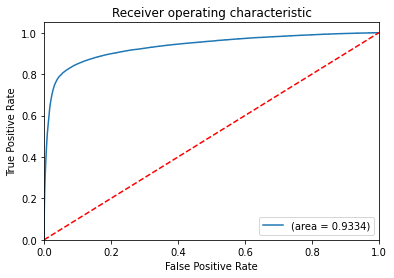

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
False_positive_rate, Recall, thresholds = roc_curve( y_test, y_pred )

plt.figure()
plt.plot(False_positive_rate, Recall, label='(area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()